# Analyzing Supply Chains with Amazon Neptune

Amazon Neptune is a fast, fully managed graph database service. In this notebook, we'll be showing how you can use Amazon Neptune to gather insights into your supply chain, which can be represented as a highly connected set of entities.

Here is the sample graph data model we'll be using:

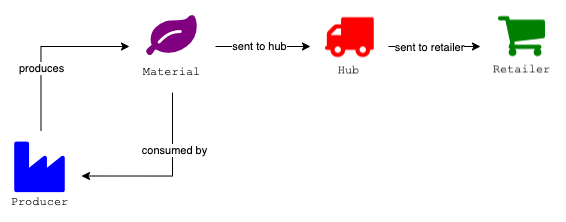

- **Materials** are goods that are produced by a factory or farm (i.e. producer), and can represent anything from raw ingredients, to finished consumer-ready products, and everything in between.
- **Producers** are entities that produce materials, and can consume other materials. Producers that produce materials that aren't consumed by other producers are tier 1 producers. Tier 1 producers can send the same material to multiple hubs.
- **Hubs** are transportation centers where consumer-ready products are sent. Hubs deliver these products to retailers. Hubs can deliver the same product to multipler retailers. 



# Loading the data

First, we'll load our sample supply chain data. Run the cell below to get the location of the S3 bucket that holds the data:

In [ ]:
import os

WORKSHOP_ASSETS_BUCKET = os.environ['WORKSHOP_ASSETS_BUCKET']
WORKSHOP_ASSETS_PREFIX = os.environ['WORKSHOP_ASSETS_PREFIX']


Then run the below cell, and click the **Submit** button to load the supply chain data.

In [ ]:
%load --source s3://{WORKSHOP_ASSETS_BUCKET}/{WORKSHOP_ASSETS_PREFIX}resources/data/supply-chain/

### Set visualization options 

The Neptune Notebooks give us the ability to generate visualizations directly from queries. These visualizations are created using the [Vis.js](https://visjs.org/) library, and we can customize how our visualizations appear. 

To make our visualizations more interesting, we'll configure a few of these parameters. Run the below cell, which will customize our visualizations with icons that represent each type of node in our graph. It will also adjust the physics and layout so that we can more easily see natural hierarchies within our data.

In [ ]:
%%graph_notebook_vis_options
{
  "nodes": {
    "borderWidthSelected": 0,
    "borderWidth": 0,
    "color": {
      "background": "rgba(210, 229, 255, 1)",
      "border": "transparent",
      "highlight": {
        "background": "rgba(9, 104, 178, 1)",
        "border": "rgba(8, 62, 100, 1)"
      }
    },
    "shadow": {
      "enabled": false
    },
    "shape": "circle",
    "widthConstraint": {
      "minimum": 70,
      "maximum": 70
    },
    "font": {
      "face": "courier new",
      "color": "black",
      "size": 12
    }
  },
  "edges": {
    "color": {
      "inherit": false
    },
    "smooth": {
      "enabled": true,
      "type": "straightCross"
    },
    "arrows": {
      "to": {
        "enabled": true,
        "type": "arrow"
      }
    },
    "font": {
      "face": "courier new"
    }
  },
  "interaction": {
    "hover": true,
    "hoverConnectedEdges": true,
    "selectConnectedEdges": false
  },
  "physics": {
    "hierarchicalRepulsion": {
      "centralGravity": 0
    },
    "minVelocity": 0.75,
    "solver": "hierarchicalRepulsion"
  },
  "layout": {
    "hierarchical": { 
      "enabled": true,
      "direction": "UD",
      "sortMethod": "directed",
      "edgeMinimization":true,
      "parentCentralization":true,
      "nodeSpacing":50}
  },
    "groups": {
        "Material": {
          "shape": "icon",
          "icon": {
            "face": "FontAwesome",
            "code": "\uf06c",
            "color": "purple"
          }
        },
        "Producer": {
          "shape": "icon",
          "icon": {
            "face": "FontAwesome",
            "code": "\uf275",
            "color": "blue"
          }
        },
        "Hub": {
          "shape": "icon",
          "icon": {
            "face": "FontAwesome",
            "code": "\uf0d1",
            "color": "red"
          }
        },
        "Retailer": {
          "shape": "icon",
          "icon": {
            "face": "FontAwesome",
            "code": "\uf07a",
            "color": "green"
          }
        }
    }
}


### Visualize our whole network

Now we can visualize our entire supply chain - run the cell below and click on the **Graph** tab to get a bird's eye view of our supply chain from end-to-end.

In [ ]:
%%gremlin

g.V() 
 .hasLabel('Material','Producer','Hub','Retailer')
 .bothE().otherV()
 .path().by(elementMap())

# Finding supply chains of a certain depth

Our supply chain graph does not explicitly maintain the tier number of each producer. This is because if we want to extend our supply chain on either end, we can do so without having to also update tier numbers. Instead, we can use the following definitions to find producers of a certain tier:

- **Tier 1 producers**: The highest tier producer (tier 1), is the producer that *produces materials that do not get consumed by other producers, and are sent to hubs*
- **Tier X producers**: The lowest tier producer (tier X), is the producer that *produces materials and does not consume materials*
- **Tier N producers**: A tier N producer (where  1 < N < X) *produces materials that get consumed by a tier N-1 producer* 

### Finding tier 1 producers

The highest tier producer (tier 1), is the producer that *produces materials that do not get consumed by other producers, and are sent to hubs* - i.e. given by the below query:

In [ ]:
%%gremlin --store-to t1

g.V().hasLabel('Producer')
 .where(out('produces').and(out('consumed_by').count().is(eq(0)), out('sent_to_hub').count().is(neq(0))))
 .id()


And we can visualize the upstream chains of these tier 1 producers - run the cell below and click the **Graph** tab:

In [ ]:
%%gremlin

g.V(${t1})
 .repeat(outE().inV()).until(out().count().is(eq(0)))
 .path().by(elementMap())

We can also write the above queries using openCypher, a SQL-inspired, declarative graph query language:

In [ ]:
%%oc 

MATCH (t1:Producer)-[:produces]->(p1:Material)
WHERE NOT exists( (p1)-[:consumed_by]->(:Producer) ) AND (p1)-[:sent_to_hub]->(:Hub)
RETURN DISTINCT id(t1)


In [ ]:
%%oc 

MATCH (t1:Producer)-[:produces]->(p1:Material)
WHERE NOT exists( (p1)-[:consumed_by]->(:Producer) ) AND (p1)-[:sent_to_hub]->(:Hub)
WITH DISTINCT t1 AS t1
MATCH p = (t1)-[:produces]->(:Material)-[:sent_to_hub]->(:Hub)-[:sent_to_retailer]->(:Retailer)
RETURN p

### Finding tier X producers

The lowest tier producer (tier X), is the producer that *produces materials and does not consume materials -* i.e. given by the below query:

In [ ]:
%%gremlin

g.V().hasLabel('Producer')
 .where(in('consumed_by').count().is(eq(0)))

We can visualize how a material produced by a tier X producer is used in final materials that get sent to hubs. Let's examine one of these tier X producers, Producer-103. Run the cell below and click the **Graph** tab:

In [ ]:
%%gremlin -d T.id -l 40

g.V('Producer-103').outE('produces').inV()
 .repeat(outE('consumed_by').inV().outE('produces').inV().simplePath())
 .until(out('sent_to_hub'))
 .outE('sent_to_hub').inV()
 .path()
 .by(elementMap())
 .limit(500)

### Finding tier N producers

A tier N producer (where  1 < N < X) *produces materials that get consumed by a tier N-1 producer* - i.e. given by the below query:

In [ ]:
N = 3

In [ ]:
%%gremlin --store-to tN

g.V().hasLabel('Producer')
 .where(repeat(out('produces').out('consumed_by')).times(${N}).count().is(eq(0)))
 .id()
 


Similarly, we can visualize the producers upstream of our tier N producers:

In [ ]:
X = N - 1

In [ ]:
%%gremlin

g.V(${tN})
 .repeat(outE('produces').inV().outE('consumed_by').inV().simplePath())
 .times(${X})
 .outE('produces').inV()
 .outE('sent_to_hub').inV()
 .path().by(elementMap())

# Understanding our supply chain

### Finding how two materials are related

Perhaps we'd like to know if - and how - two given materials are related. For example, if material *m1* has a dependency on material *m2*. If it does, we know that a shortage of *m2* could affect the supply of *m1*.

We can use the following query to understand if Material-113 is related to Material-1, and if so, via which materials and producers.

In [ ]:
m1 = 'Material-113'
m2 = 'Material-1'

In [ ]:
%%gremlin -d T.id -l 40

g.V('${m1}')
 .repeat(outE('consumed_by').inV().outE('produces').inV().simplePath())
 .until(hasId('${m2}'))
 .path()
 .limit(10)

Again, we can do a similar query using OpenCypher. We use the concept of variable length paths, as indicated by the `*`. Here, our query is saying "*find me all the paths between m1 and m2, regardless of length*".

In [ ]:
%%oc

MATCH p = (m1 {`~id`:'${m1}'})-[*]->(m2 {`~id`:'${m2}'})
RETURN p
LIMIT 10


### Understanding the sustainability impact of a finished material

Perhaps we want to find finished materials that are made from sub-materials that are produced by producers that don't meet our sustainability requirements. As part of our data model, we've added a number property called `sustainability_score` to each producer. We can modify our previous query to not only find all the sub-materials of a particular material, but also check that the sustainability score of each producer is below a certain threshold (our sustainability requirements).

Run the cell below to find all the producers involved in the finished product Material-1, that do not meet our sustainability score requirement of 51 or higher.

In [ ]:
%%gremlin -d T.id -l 40

g.V('Material-1')
 .repeat(inE('produces').outV().has('sustainability_score',lte(50)).as('p')
         .inE('consumed_by').outV()
         .simplePath()
 )
 .until(in('produces').in('consumed_by').count().is(eq(0)))
 .select('p')
 .path()
 .by(elementMap())


We can slightly modify the above query to print a list of the offending producers, and their associated sustainability score.

In [ ]:
%%gremlin

g.V('Material-1')
 .repeat(inE('produces').outV().has('sustainability_score',lte(50))
         .inE('consumed_by').outV()
         .simplePath()
 )
 .until(in('produces').in('consumed_by').count().is(eq(0)))
 .path().unfold().hasLabel('Producer').dedup()
 .project('Producer','Sustainability Score')
 .by(id())
 .by(values('sustainability_score'))
 .order().by('Sustainability Score', asc)


# Using graph algorithms to find the most important materials, producers, and hubs in our supply chain

So far we've been answering our business questions by using queries that look for certain patterns in our graph. We can continue to apply this thinking to answer business questions like "*What are the most important materials, producers, and hubs in our supply chain?*" - for example, we might choose to define that the most important producer is the producer that produces the most materials, or the most important hub is the one that receives the most materials. 

However, we can also use graph algorithms to answer those questions. For this next section, we'll be using the [AWS SDK for Pandas integration with Neptune](https://aws-sdk-pandas.readthedocs.io/en/stable/api.html#amazon-neptune). The integration provides us an easy way to write our graph data into Pandas DataFrames, which we can then use with algorithms provided by open source analytics libraries like iGraph, NetworkX, and more.

To get started, let's first install iGraph, which is the analytics library we'll be using for this example. You'll see a note that looks like this after running the cell:

```
Note: you may need to restart the kernel to use updated packages.
```

After the note appears, from the top dropdown menu of the notebook click on *Kernel* > *Restart*, then refresh your browser.

In [ ]:
pip install igraph -q

Now we can import all the necessary libraries and set our Neptune configurations. 

In [ ]:
import awswrangler as wr
import pandas as pd
import igraph as ig
import graph_notebook as gn
from graph_notebook.configuration.generate_config import AuthModeEnum

# Get the configuration information for the notebook
config = gn.configuration.get_config.get_config()
iam=True if config.auth_mode==AuthModeEnum.IAM else False


### What are the most important producers in my supply chain?

Let's revisit our question of "*What are the most important materials, producers, and hubs in our supply chain?*" It's good for us to understand the weak or potential points of influence in our network of producers. Knowing this information can help us better plan for future shortages or how to shift production if a key producer goes down.

A set of algorithms called [centrality algorithms](https://en.wikipedia.org/wiki/Centrality) can help us understand these important points in our network. 

Before we get started with these algorithms, let's extract our network of producers into a DataFrame using the [execute_gremlin](https://aws-sdk-pandas.readthedocs.io/en/stable/stubs/awswrangler.neptune.execute_gremlin.html#awswrangler.neptune.execute_gremlin) function provided by the AWS SDK for Pandas. We provide the function a Gremlin query that extracts the producer-to-producer network, via the materials they each produce. Our extracted connections will represent how each producer depends on the materials produced and consumed by other producers. The table produced after running the cell below, can be read as the producer in the source column depends on the corresponding producer in the target column.


In [ ]:
# Retrieve data from Neptune
client = wr.neptune.connect(config.host, config.port, iam_enabled=iam)
query = """g.V().hasLabel('Producer').as('source').in('consumed_by')
.in('produces').as('target').project('source','target')
.by(select('source').id()).by(select('target').id())
"""
df = wr.neptune.execute_gremlin(client, query)
display(df.head(10))

After we extract our graph data, we can create an iGraph graph with the [TupleList](https://igraph.org/python/api/latest/igraph.Graph.html#TupleList) class:

In [ ]:
# Create a graph from the results returned
g = ig.Graph.TupleList(df.itertuples(index=False), directed=True, weights=False)


### How do we define importance in a graph?

Centrality algorithms help us understand how important a particular node in a graph may be, relative to the rest of the graph structure. Previously we answered our question of importance by counting how many materials a producer produces. However, that value is independent of all other producers, and doesn't give us context about how important that producer is relative to all the other producers.

Importance can mean many different things - for example, it could be the node that has the most connections to other nodes, or even how close a node is to all other nodes. In the next few cells, we'll calculate the values of a few different centrality algorithms that each define "importantance" in a different way:

- **PageRank:** The PageRank algorithm was originally used by Google as a way to rank website relevance in search engine results. It's a way of measuring the relative importance of a website (i.e. node), not just by considering the count of references to it but the weight of each one as well. The larger the PageRank value, the more "influential" that node is. In our example, a producer that has a larger PageRank value indicates that it is connected to not just many producers, but also producers that are also connected to many other producers.

- **Closeness centrality:** The closeness centrality value of a node is the average length of the shortest path between that node and all the other nodes in the graph. The smaller the value, the more "centrally" located the node is in the graph (e.g. relative to a node that might live at the edge of the graph). In our example, a producer that is more "centrally" located within our graph represents a producer that is the heart of our supply chain.

- **Betweenness centrality:** The betweenness centrality value of a node is the number of times that that node appears in a shortest path between all the pairs of nodes in the graph. The higher the value, the more critical that node is - it means that node acts as a bridge for many shortest paths between a given pair of nodes. In our example, a producer with a large betweenness centrality value is critical to our supply chain - if it goes down, it can have a widespread effect on the surrounding producers that depend on it for materials.


#### Calculate the [PageRank](https://igraph.org/python/api/latest/igraph.Graph.html#pagerank) values for each Producer

In [ ]:
pr = g.pagerank()

#### Calculate the [closeness](https://igraph.org/python/api/latest/igraph._igraph.GraphBase.html#closeness) between Producers

In [ ]:
cl = g.closeness()

#### Calculate the [betweenness](https://igraph.org/python/api/latest/igraph._igraph.GraphBase.html#betweenness) between Producers

In [ ]:
bet = g.betweenness()

Now that we have calculated the PageRank, closeness centrality, and betweenness centrality values of our producers, let's write these values back into our graph as properties on each of our producers. 

The AWS SDK for Pandas library provides us a handy function to write back our results to our graph via a DataFrame, through the [to_property_graph](https://aws-sdk-pandas.readthedocs.io/en/stable/stubs/awswrangler.neptune.to_property_graph.html#awswrangler.neptune.to_property_graph) function. 

Let's first join our results into a DataFrame:

In [ ]:
prows = []
prrows = []
clrows = []
betrows = []

for v in enumerate(g.vs):
    prows.append(v[1]['name'])
    
for v in enumerate(pr):
    prrows.append(v[1])

for v in enumerate(cl):
    clrows.append(v[1])
    
for v in enumerate(bet):
    betrows.append(v[1])

data = {
    '~id': prows,
    'pagerank(single)': prrows,
    'closeness(single)': clrows,
    'betweenness(single)': betrows
}

new_df = pd.DataFrame(data)
print(new_df)

Then we'll use the `to_property_graph` function to write that DataFrame back into our graph:

In [ ]:
res = wr.neptune.to_property_graph(client, new_df, use_header_cardinality=True, batch_size=100)
print(res)

### Visualizing the most important producers in our network

#### PageRank
We can now use our queries to check that values we previously calculated, were added as properties to our producer nodes. Let's find the most influential producers in our network (i.e. the producer node with the largest PageRank value):

In [ ]:
%%gremlin

g.V().hasLabel('Producer').has('pagerank')
 .project('Producer','PageRank value')
 .by(id())
 .by(values('pagerank'))
 .order().by('PageRank value', desc)

It turns out that the top 10 producers with the highest PageRank values are producers from the bottom half of our tiers (tier 4 to 6). This makes sense, as lower tier producers produce materials that all the upper tier producers depend on. 

Let's take a look at the immediate surrounding graph of our most influential producer, Producer-100. By counting all the producer nodes in the visualization, we get the number of producers that directly depend on Producer-100, both upstream and downstream.

In [ ]:
%%gremlin -d T.id -l 40

g.V('Producer-100')
 .bothE().otherV() // materials produced/consumed by Producer-100
 .bothE().otherV() // producers related to Producer-100 via produced/consumed materials
 .path()
 

Let's hop out one level of producers again, to find the producers that are dependent on the producers that are dependent on Producer-100 (e.g. 2-hop neighborhood of producers). Even considering just a small radius, it's clear that Producer-100 has influence over many other producers.

In [ ]:
%%gremlin -d T.id -l 40

g.V('Producer-100')
 .bothE().otherV() // materials produced/consumed by Producer-100
 .bothE().otherV() // producers related to Producer-100 via produced/consumed materials
 .bothE().otherV() // materials produced/consumed by producers dependent on Producer-100
 .bothE().otherV() // producers related to producers dependent on Producer-100
 .path()

#### Closeness

With this next query, let's find the most central producers in our network:

In [ ]:
%%gremlin

g.V().hasLabel('Producer').has('closeness')
 .project('Producer','Closeness value')
 .by(id())
 .by(values('closeness'))
 .order().by('Closeness value', asc)

The top 10 producers with the smallest closeness values represent the top 10 most centrally located producers in our network. Again, these top 10 producers come from our bottom third tier of producers (tier 5 and 6), indicating that producers that create sub-materials for higher tier producers are the heart of our supply chain - many other producers depend and rely on them.

#### Betweenness
With the following query, let's find the most critical producers in our network:

In [ ]:
%%gremlin

g.V().hasLabel('Producer').has('betweenness')
 .project('Producer','Betweenness value')
 .by(id())
 .by(values('betweenness'))
 .order().by('Betweenness value', desc)

The top 10 producers with the largest betweenness values represent the top 10 most critical producers - i.e. the producers that act as "bridges" between one part of the producer network to the other. Our top 10 producers with the largest betweenness values come from the middle tiers of producers (tiers 3, 4, and 5). 